In [2]:
import torch
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
import sys
import copy
sys.path.append('../')

from models import (
    AE,
    IRAE    
)

from models.modules import (
    FC_vec,
)

from bezier import Bezier, demo2bezier, bezier2traj, bezier_Riemannian_metric

from utils.utils import label_to_color
from sklearn.mixture import GaussianMixture

device = f'cuda:0'   

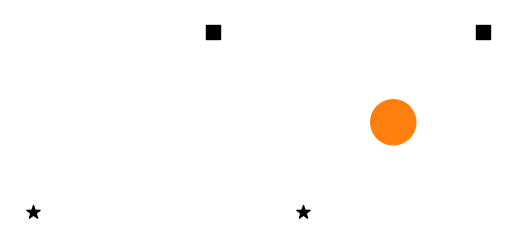

In [3]:
# Env setting
workspace = [[-1, 1], [-1, 1]]
init = [0.8, 0.8]
goal = [-0.8, -0.8]

fig, axs = plt.subplots(1, 2)
for i in range(2):
    axs[i].set_xlim(workspace[0])
    axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=100, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=100, c='k')
    if i == 1:
        Obs = Circle(xy=[0,0], radius=0.2, color='tab:orange')
        axs[i].add_patch(Obs)
plt.show()

In [10]:
# EXP 1
trajs1 = [
    np.load('../datasets/poc/class1_4.npy'),
    np.load('../datasets/poc/class1_2.npy'),
    np.load('../datasets/poc/class1_1.npy'),
    np.load('../datasets/poc/class1.npy'),
]
trajs2 = [
    np.load('../datasets/poc/class2_4.npy'),
    np.load('../datasets/poc/class2_2.npy'),
    np.load('../datasets/poc/class2_3.npy'),
    np.load('../datasets/poc/class2.npy'),
]

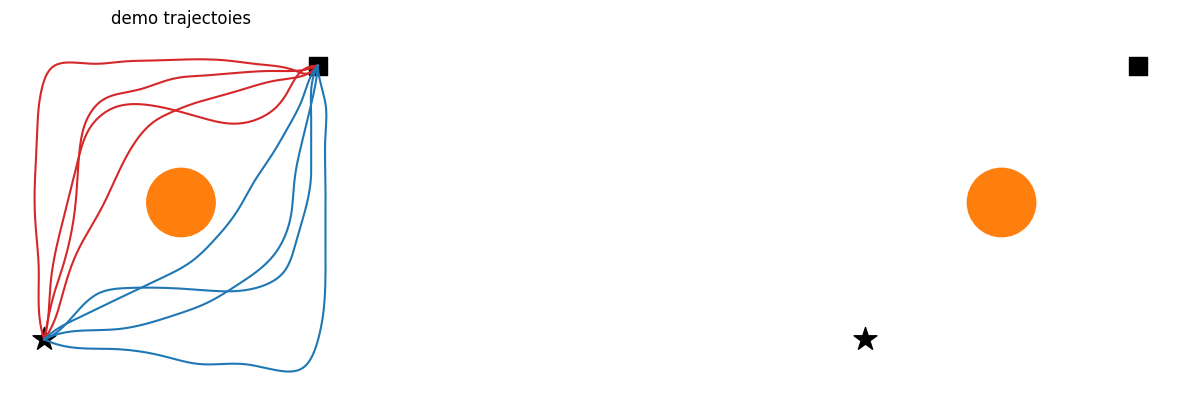

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in [0, 2]:
    axs[i].set_xlim(workspace[0])
    axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    Obs = Circle(xy=[0,0], radius=0.2, color='tab:orange')
    axs[i].add_patch(Obs)
    
    if i == 0:
        for traj in trajs1:
            axs[i].plot(traj[0, :, 0], traj[0, :, 1], c='tab:red')
        
        for traj in trajs2:
            axs[i].plot(traj[0, :, 0], traj[0, :, 1], c='tab:blue')
        
axs[1].axis('off')

axs[0].set_title('demo trajectoies')
plt.show()

In [12]:
trajs_class1 = torch.cat([torch.tensor(traj[0], dtype=torch.float32).unsqueeze(0) for traj in trajs1], dim=0)
trajs_class2 = torch.cat([torch.tensor(traj[0], dtype=torch.float32).unsqueeze(0) for traj in trajs2], dim=0)

In [13]:
trajs = torch.cat([trajs_class1, trajs_class2], dim=0)
targets = torch.tensor([0, 0, 0, 0, 1, 1, 1, 1])

In [14]:
num_control_points = 10

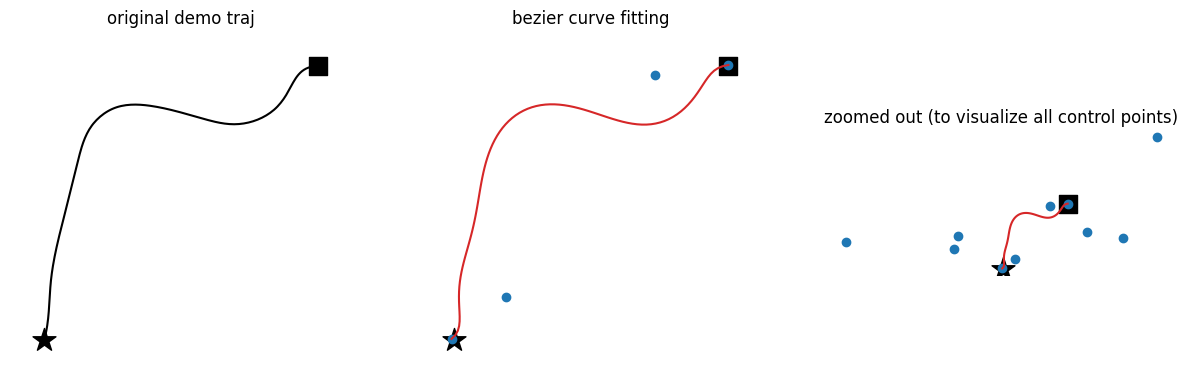

In [15]:
bezier = Bezier(dof=2, T=5, num_control_points=num_control_points, num_models=len(trajs))
bezier.LfD(q_demo_traj=trajs, T=5)

t = torch.linspace(0, 5, 100).view(1, 100)
traj = bezier.curve(t)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in [0, 1, 2]:
    if i in [0, 1]:
        axs[i].set_xlim(workspace[0])
        axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    

axs[0].plot(trajs[0, :, 0], trajs[0, :, 1], c='k')
axs[1].plot(traj[0, :, 0], traj[0, :, 1], c='tab:red')
axs[1].scatter(bezier.theta[0, :, 0], bezier.theta[0, :, 1], c='tab:blue')
axs[2].plot(traj[0, :, 0], traj[0, :, 1], c='tab:red')
axs[2].scatter(bezier.theta[0, :, 0], bezier.theta[0, :, 1], c='tab:blue')

axs[0].set_title('original demo traj')
axs[1].set_title('bezier curve fitting')
axs[2].set_title('zoomed out (to visualize all control points)')

plt.show()

In [16]:
params = demo2bezier(trajs, T=5, num_control_points=num_control_points)

### VANILA AE

In [17]:
encoder = FC_vec(
    in_chan=num_control_points*2,
    out_chan=2,
    l_hidden=[256, 256, 256, 256],
    activation=['elu', 'elu', 'elu', 'elu'],
    out_activation='linear'
)
decoder = FC_vec(
    in_chan=2,
    out_chan=num_control_points*2,
    l_hidden=[256, 256, 256, 256],
    activation=['elu', 'elu', 'elu', 'elu'],
    out_activation='linear'
)
ae = AE(encoder=encoder, decoder=decoder, init_final_projection=True)
ae.to(device);

In [18]:
optimizer = torch.optim.Adam(ae.parameters(), lr=0.0001)

best_recon = torch.inf
for epoch in range(1000):
    loss = ae.train_step(params.squeeze(-1).to(device), optimizer)
    if epoch%50 == 0:
        loss = loss['loss']
        recon = ae.validation_step(params.squeeze(-1).to(device))['loss']
        if recon < best_recon:
            best_ae = copy.copy(ae)
            best_recon = recon
            print(f'best_model_copied: {recon} < {best_recon}')
        print(f'{epoch}, total_loss: {loss}, recon_loss: {recon}')

best_model_copied: 1.323681354522705 < 1.323681354522705
0, total_loss: 1.338744878768921, recon_loss: 1.323681354522705
best_model_copied: 0.3758429288864136 < 0.3758429288864136
50, total_loss: 0.3845665454864502, recon_loss: 0.3758429288864136
best_model_copied: 0.04731199890375137 < 0.04731199890375137
100, total_loss: 0.050072528421878815, recon_loss: 0.04731199890375137
best_model_copied: 0.01736951805651188 < 0.01736951805651188
150, total_loss: 0.01754341460764408, recon_loss: 0.01736951805651188
best_model_copied: 0.01095518283545971 < 0.01095518283545971
200, total_loss: 0.011073235422372818, recon_loss: 0.01095518283545971
best_model_copied: 0.005608834326267242 < 0.005608834326267242
250, total_loss: 0.005695056635886431, recon_loss: 0.005608834326267242
best_model_copied: 0.0023589737247675657 < 0.0023589737247675657
300, total_loss: 0.002407247433438897, recon_loss: 0.0023589737247675657
best_model_copied: 0.0007750557851977646 < 0.0007750557851977646
350, total_loss: 0.0

C:\Users\21448\AppData\Local\Temp\ipykernel_18952\2867521138.py:101: UserWarning: No contour levels were found within the data range.
  contour = axs[1].contour(


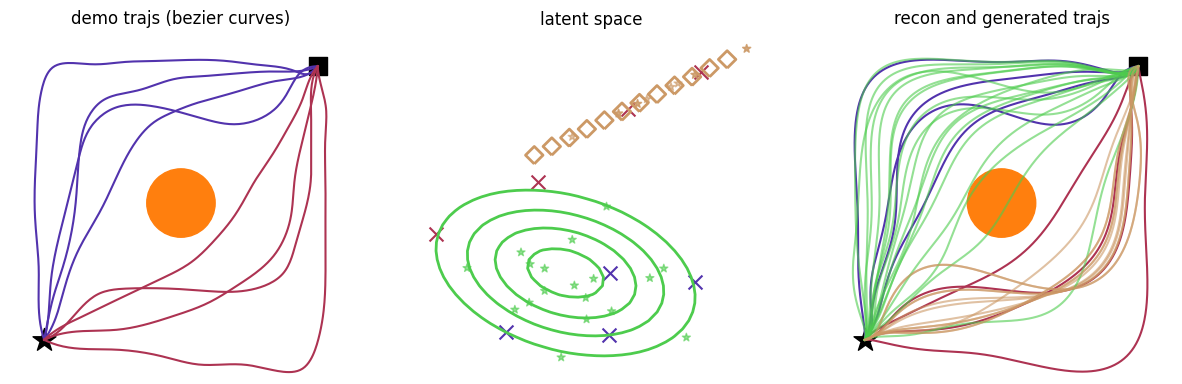

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

Z = best_ae.encode(params.to(device)).detach().cpu()

for i in [0, 2]:
    axs[i].set_xlim(workspace[0])
    axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    Obs = Circle(xy=[0,0], radius=0.2, color='tab:orange')
    axs[i].add_patch(Obs)
    if i == 0:
        for traj in trajs_class1:
            axs[i].plot(traj[:, 0], traj[:, 1], c=(0.2*np.array([0.8,0.2,0.2]) + (1-0.2)*np.array([0.2,0.2,0.8])).reshape(1, -1))
        for traj in trajs_class2:
            axs[i].plot(traj[:, 0], traj[:, 1], c=(0.8*np.array([0.8,0.2,0.2]) + (1-0.8)*np.array([0.2,0.2,0.8])).reshape(1, -1))

for i in range(len(Z)):
    c = 0.2 + 0.6*targets[i]
    axs[1].scatter(
        Z[i, 0], 
        Z[i, 1], 
        marker='x', 
        s=100, 
        c=(c*np.array([0.8,0.2,0.2]) + (1-c)*np.array([0.2,0.2,0.8])).reshape(1, -1)
        )

axs[1].set_aspect('equal')
axs[1].axis('off')

# gen_params= best_ae.decode(z_interp.view(len(z_interp), 1).to(device))
# gen_trajs = dmp2traj(gen_params, dof=2, num_points=500, T=5, dt=0.01).detach().cpu()

recon_params = best_ae.decode(Z.to(device))
gen_trajs = bezier2traj(recon_params, dof=2, traj_len=500, T=5).detach().cpu()

for i, traj in enumerate(gen_trajs):
    c = 0.2 + 0.6*targets[i].item()
    axs[2].plot(
        traj[:, 0], 
        traj[:, 1], 
        c=(c*np.array([0.8,0.2,0.2]) + (1-c)*np.array([0.2,0.2,0.8])).reshape(1, -1)
        , alpha=1
        )


## SAMPLING
num_calsses = 2
gm = GaussianMixture(n_components=num_calsses, random_state=0).fit(Z)
thr = gm.score_samples(Z).min()
    
sample_z = []
sample_y = []
num_samples = 0
while num_samples < 30:
    temp_z, temp_y = gm.sample(30)
    accept_idx = gm.score_samples(temp_z) > thr
    temp_y = temp_y[accept_idx]
    temp_z = temp_z[accept_idx]
    num_samples+=len(temp_z)
    sample_z.append(temp_z)
    sample_y.append(temp_y)
sample_z = np.concatenate(sample_z, axis=0)[:30]
sample_y = np.concatenate(sample_y, axis=0)[:30]

c = sample_y.reshape(-1,1)

axs[1].scatter(
    sample_z[:, 0], 
    sample_z[:, 1], 
    c=(c*np.array([[0.3,0.8,0.3]]) + (1-c)*np.array([[0.8,0.6,0.4]])).reshape(-1, 3), 
    marker='*', alpha=0.6)
        
sample_x = best_ae.decode(torch.tensor(sample_z, dtype=torch.float32).to(device))
sampled_trajs = bezier2traj(
    sample_x, 2, 5, traj_len=500).detach().cpu()
for traj, label in zip(sampled_trajs, sample_y):
    color = (label*np.array([[0.3,0.8,0.3]]) + (1-label)*np.array([[0.8,0.6,0.4]])).reshape(-1, 3)
    axs[2].plot(traj[:, 0], traj[:, 1], c=color, alpha=0.6)

mu = gm.means_
cov = gm.covariances_

xmin, xmax = axs[1].get_xbound()
ymin, ymax = axs[1].get_ybound()

for i, (mu, cov) in enumerate(zip(gm.means_, gm.covariances_)):
    tempZ = sample_z[sample_y == i]
    x = np.linspace(xmin, xmax, 40)
    y = np.linspace(ymin, ymax, 40)
    xx, yy = np.meshgrid(x, y) 
    delta = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1) - mu.reshape(1, -1)

    zz = np.exp(np.diagonal(
        -(delta@np.linalg.inv(cov)@delta.transpose())
    )/2)
    
    c = sample_y[sample_y == i].reshape(-1,1)
    contour = axs[1].contour(
        xx.reshape(40, 40), 
        yy.reshape(40, 40), 
        zz.reshape(40, 40),
        levels=[0.3, 0.5, 0.7, 0.9, 0.9999], 
        colors=(c*np.array([[0.3,0.8,0.3]]) + (1-c)*np.array([[0.8,0.6,0.4]])).reshape(-1, 3),
        linewidths=2,
        )

axs[0].set_title('demo trajs (bezier curves)')
axs[1].set_title('latent space')
axs[2].set_title('recon and generated trajs')

plt.show()

## IRAE

In [22]:
encoder = FC_vec(
    in_chan=num_control_points*2,
    out_chan=2,
    l_hidden=[256, 256, 256, 256],
    activation=['elu', 'elu', 'elu', 'elu'],
    out_activation='linear'
)
decoder = FC_vec(
    in_chan=2,
    out_chan=num_control_points*2,
    l_hidden=[256, 256, 256, 256],
    activation=['elu', 'elu', 'elu', 'elu'],
    out_activation='linear'
)
ae = IRAE(encoder=encoder, decoder=decoder, init_final_projection=True, dim=2, metric='bezier', T=5, num_control_points=num_control_points, iso_reg=0.1)
ae.to(device);

In [23]:
optimizer = torch.optim.Adam(ae.parameters(), lr=0.0001)

best_recon = torch.inf
for epoch in range(1000):
    loss = ae.train_step(params.squeeze(-1).to(device), optimizer)
    if epoch%50 == 0:
        loss = loss['loss']
        recon = ae.validation_step(params.squeeze(-1).to(device))['loss']
        if recon < best_recon:
            best_ae = copy.copy(ae)
            best_recon = recon
            print(f'best_model_copied: {recon} < {best_recon}')
        print(f'{epoch}, total_loss: {loss}, recon_loss: {recon}')

best_model_copied: 1.3661856651306152 < 1.3661856651306152
0, total_loss: 1.453481674194336, recon_loss: 1.3661856651306152
best_model_copied: 0.48118856549263 < 0.48118856549263
50, total_loss: 0.6037871241569519, recon_loss: 0.48118856549263
best_model_copied: 0.07615533471107483 < 0.07615533471107483
100, total_loss: 0.12855370342731476, recon_loss: 0.07615533471107483
best_model_copied: 0.03305649012327194 < 0.03305649012327194
150, total_loss: 0.0841626524925232, recon_loss: 0.03305649012327194
best_model_copied: 0.02460986189544201 < 0.02460986189544201
200, total_loss: 0.08138750493526459, recon_loss: 0.02460986189544201
best_model_copied: 0.01694081909954548 < 0.01694081909954548
250, total_loss: 0.08207780867815018, recon_loss: 0.01694081909954548
best_model_copied: 0.013547781854867935 < 0.013547781854867935
300, total_loss: 0.08959422260522842, recon_loss: 0.013547781854867935
best_model_copied: 0.00942678190767765 < 0.00942678190767765
350, total_loss: 0.061541348695755005,

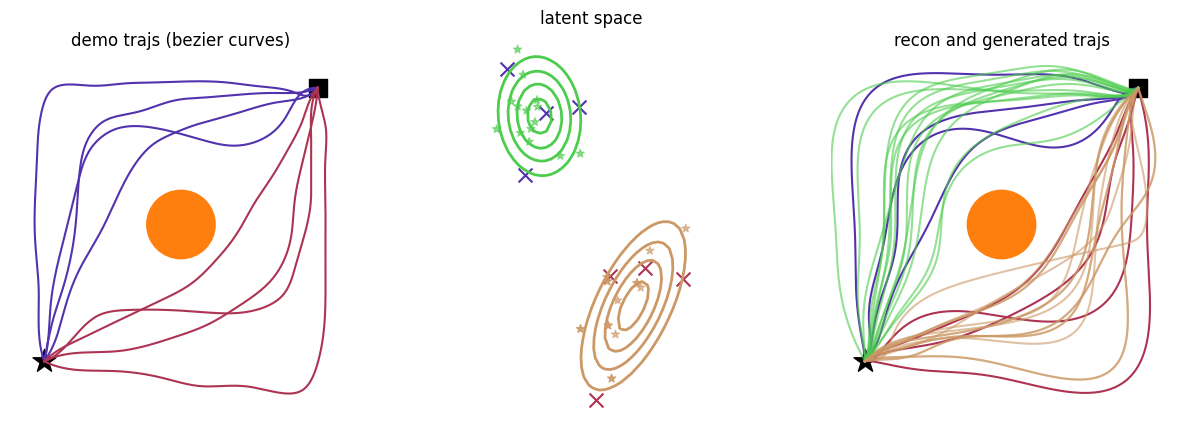

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

Z = best_ae.encode(params.to(device)).detach().cpu()

for i in [0, 2]:
    axs[i].set_xlim(workspace[0])
    axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    Obs = Circle(xy=[0,0], radius=0.2, color='tab:orange')
    axs[i].add_patch(Obs)
    if i == 0:
        for traj in trajs_class1:
            axs[i].plot(traj[:, 0], traj[:, 1], c=(0.2*np.array([0.8,0.2,0.2]) + (1-0.2)*np.array([0.2,0.2,0.8])).reshape(1, -1))
        for traj in trajs_class2:
            axs[i].plot(traj[:, 0], traj[:, 1], c=(0.8*np.array([0.8,0.2,0.2]) + (1-0.8)*np.array([0.2,0.2,0.8])).reshape(1, -1))

for i in range(len(Z)):
    c = 0.2 + 0.6*targets[i]
    axs[1].scatter(
        Z[i, 0], 
        Z[i, 1], 
        marker='x', 
        s=100, 
        c=(c*np.array([0.8,0.2,0.2]) + (1-c)*np.array([0.2,0.2,0.8])).reshape(1, -1)
        )

axs[1].set_aspect('equal')
axs[1].axis('off')

# gen_params= best_ae.decode(z_interp.view(len(z_interp), 1).to(device))
# gen_trajs = dmp2traj(gen_params, dof=2, num_points=500, T=5, dt=0.01).detach().cpu()

recon_params = best_ae.decode(Z.to(device))
gen_trajs = bezier2traj(recon_params, dof=2, traj_len=500, T=5).detach().cpu()

for i, traj in enumerate(gen_trajs):
    c = 0.2 + 0.6*targets[i].item()
    axs[2].plot(
        traj[:, 0], 
        traj[:, 1], 
        c=(c*np.array([0.8,0.2,0.2]) + (1-c)*np.array([0.2,0.2,0.8])).reshape(1, -1)
        , alpha=1
        )


## SAMPLING
num_calsses = 2
gm = GaussianMixture(n_components=num_calsses, random_state=0).fit(Z)
thr = gm.score_samples(Z).min()
    
sample_z = []
sample_y = []
num_samples = 0
while num_samples < 30:
    temp_z, temp_y = gm.sample(30)
    accept_idx = gm.score_samples(temp_z) > thr
    temp_y = temp_y[accept_idx]
    temp_z = temp_z[accept_idx]
    num_samples+=len(temp_z)
    sample_z.append(temp_z)
    sample_y.append(temp_y)
sample_z = np.concatenate(sample_z, axis=0)[:30]
sample_y = np.concatenate(sample_y, axis=0)[:30]

c = sample_y.reshape(-1,1)
axs[1].scatter(
    sample_z[:, 0], 
    sample_z[:, 1], 
    c=(c*np.array([[0.3,0.8,0.3]]) + (1-c)*np.array([[0.8,0.6,0.4]])).reshape(-1, 3), 
    marker='*', alpha=0.6)
        
sample_x = best_ae.decode(torch.tensor(sample_z, dtype=torch.float32).to(device))
sampled_trajs = bezier2traj(
    sample_x, 2, 5, traj_len=500).detach().cpu()
for traj, label in zip(sampled_trajs, sample_y):
    color = (label*np.array([[0.3,0.8,0.3]]) + (1-label)*np.array([[0.8,0.6,0.4]])).reshape(-1, 3)
    axs[2].plot(traj[:, 0], traj[:, 1], c=color, alpha=0.6)

mu = gm.means_
cov = gm.covariances_

xmin, xmax = axs[1].get_xbound()
ymin, ymax = axs[1].get_ybound()

for i, (mu, cov) in enumerate(zip(gm.means_, gm.covariances_)):
    tempZ = sample_z[sample_y == i]
    x = np.linspace(xmin, xmax, 40)
    y = np.linspace(ymin, ymax, 40)
    xx, yy = np.meshgrid(x, y) 
    delta = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1) - mu.reshape(1, -1)

    zz = np.exp(np.diagonal(
        -(delta@np.linalg.inv(cov)@delta.transpose())
    )/2)
    
    c = sample_y[sample_y == i].reshape(-1,1)
    contour = axs[1].contour(
        xx.reshape(40, 40), 
        yy.reshape(40, 40), 
        zz.reshape(40, 40),
        levels=[0.3, 0.5, 0.7, 0.9, 0.9999], 
        colors=(c*np.array([[0.3,0.8,0.3]]) + (1-c)*np.array([[0.8,0.6,0.4]])).reshape(-1, 3),
        linewidths=2,
        )

axs[0].set_title('demo trajs (bezier curves)')
axs[1].set_title('latent space')
axs[2].set_title('recon and generated trajs')

plt.show()